In [1]:
import pandas as pd
from pathlib import Path
import random
import torch_geometric

In [2]:
import sys
import os
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
parent_parent_dir = os.path.dirname(parent_dir)

sys.path.append(parent_dir)
sys.path.append(parent_parent_dir)

from DataPipeline.preprocessing import process_encode_graph, get_subgraph_with_terminal_nodes_step, torch_geometric_to_networkx, plot_graph
from utils import sample_random_subgraph_ZINC, sample_first_atom, get_model_GNN1, get_model_GNN2, get_model_GNN3, get_optimizer, one_step, create_torch_graph_from_one_atom, load_model


In [3]:
zinc_path = Path('rndm_zinc_drugs_clean_3.csv')
zinc_df = pd.read_csv(zinc_path)

In [4]:
graph = create_torch_graph_from_one_atom(sample_first_atom())
#batch graph 
batch_graph = torch_geometric.data.Batch.from_data_list([graph])

In [5]:
graph, terminal, id_map = sample_random_subgraph_ZINC(zinc_df, 1)
batch = torch_geometric.data.Batch.from_data_list([graph])

In [6]:
sample_first_atom()

'6'

In [7]:
batch

DataBatch(x=[1, 7], edge_index=[0], edge_attr=[0, 4], batch=[1], ptr=[2])

In [8]:
GNN1_path = Path('.') / 'models/trained_models/checkpoint_epoch_247_GNN1.pt'
GNN2_path = Path('.') / 'models/trained_models/checkpoint_epoch_236_GNN2_test.pt'
GNN3_path = Path('.') / 'models/trained_models/checkpoint_epoch_100_experience_1.pt'


GNN1 = get_model_GNN1(7)
GNN2 = get_model_GNN2(7)
GNN3 = get_model_GNN3(7)

optimizer_GNN1 = get_optimizer(GNN1, lr=0.0001)
optimizer_GNN2 = get_optimizer(GNN2, lr=0.0001)
optimizer_GNN3 = get_optimizer(GNN3, lr=0.0001)

GNN1, optimizer_GNN1 = load_model(GNN1_path, GNN1, optimizer_GNN1)
GNN2, optimizer_GNN2 = load_model(GNN2_path, GNN2, optimizer_GNN2)
GNN3, optimizer_GNN3 = load_model(GNN3_path, GNN3, optimizer_GNN3)


In [9]:
# Set all models in eval mode

GNN1.eval()
GNN2.eval()
GNN3.eval()

GNN1.to('cuda')
GNN2.to('cuda')
GNN3.to('cuda')

ModelWithEdgeFeatures(
  (message_passing_layers): ModuleList(
    (0): CustomMessagePassingLayer()
    (1): CustomMessagePassingLayer()
    (2): CustomMessagePassingLayer()
    (3): CustomMessagePassingLayer()
    (4): CustomMessagePassingLayer()
    (5): CustomMessagePassingLayer()
    (6): CustomMessagePassingLayer()
    (7): CustomMessagePassingLayer()
  )
  (batch_norm_layers): ModuleList(
    (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, trac

In [10]:
output, queue = one_step(batch, [0], GNN1=GNN1, GNN2=GNN2, GNN3=GNN3, device='cuda')

current_node 0
softmax_GNN1 tensor([[7.7143e-01, 1.3967e-01, 6.3608e-02, 4.0157e-03, 1.6631e-02, 4.6174e-03,
         3.1397e-05]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[0.4780, 0.5137, 0.0070, 0.0013]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.]])


In [17]:
def full_generation():
    graph, terminal, id_map = sample_random_subgraph_ZINC(zinc_df, 1)
    output = torch_geometric.data.Batch.from_data_list([graph])
    queue = [0]
    i = 1
    while queue and i < 100:
        print(i)
        output, queue = one_step(output, queue, GNN1=GNN1, GNN2=GNN2, GNN3=GNN3, device='cuda')
        graphX = torch_geometric_to_networkx(output)
        plot_graph(graphX, atom_conversion_type='onehot', encoding_type = 'reduced')
        output = torch_geometric.data.Batch.from_data_list([output])
        i += 1
        
    return output, queue

1
current_node 0
softmax_GNN1 tensor([[8.4996e-01, 4.8142e-02, 2.2328e-04, 1.9549e-09, 1.0164e-01, 3.7280e-08,
         3.7351e-05]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[4.7281e-02, 4.4325e-01, 5.0943e-01, 4.0290e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.]])


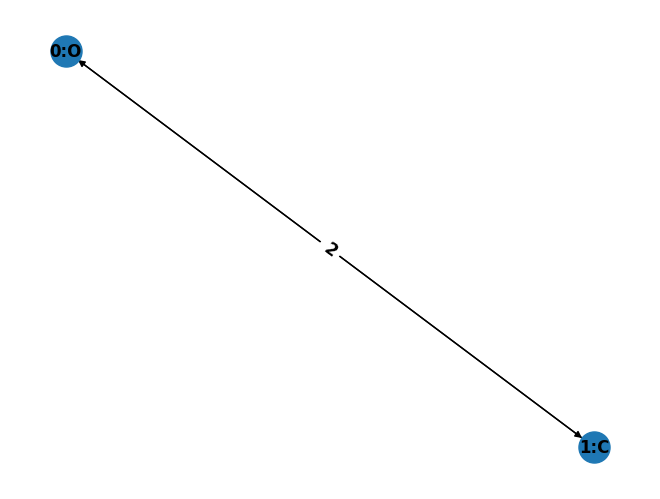

2
current_node 0
softmax_GNN1 tensor([[3.2946e-08, 7.1311e-14, 8.2069e-09, 0.0000e+00, 3.0851e-32, 0.0000e+00,
         1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


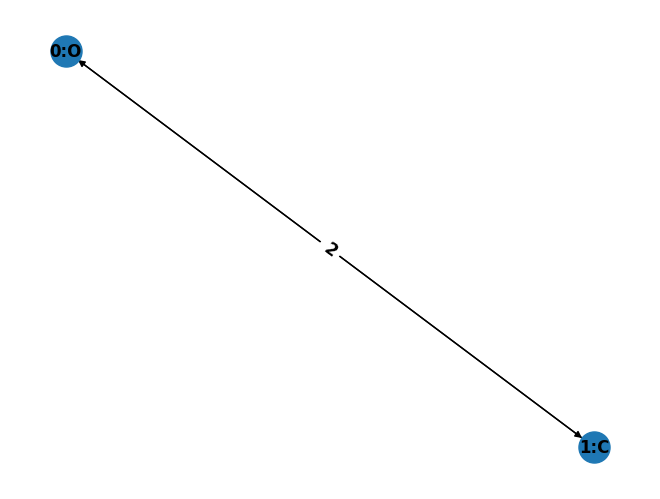

3
current_node 1
softmax_GNN1 tensor([[4.3754e-01, 4.7709e-01, 8.3887e-02, 1.0069e-05, 1.3902e-03, 8.1244e-05,
         1.3601e-07]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[3.0641e-02, 9.6936e-01, 1.9111e-06, 1.7010e-08]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0.]])


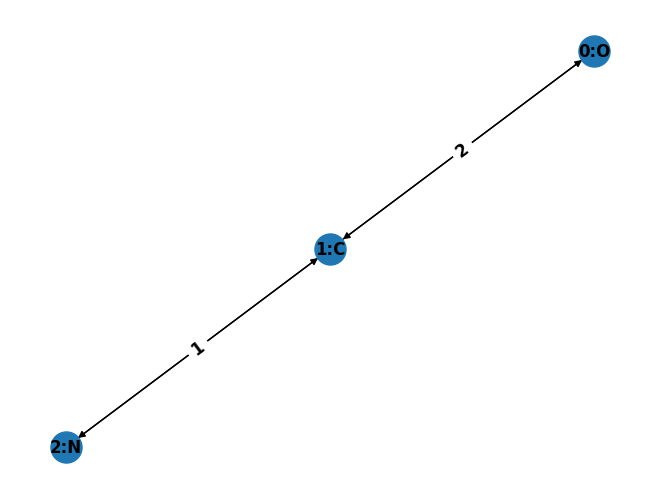

4
current_node 1
softmax_GNN1 tensor([[7.1965e-01, 2.4927e-01, 2.3213e-02, 1.5775e-04, 3.9193e-03, 5.3662e-04,
         3.2529e-03]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[0., 1., 0., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.]])
softmax_prediction3 tensor([[1.2671e-05, 1.2671e-05, 1.2671e-05, 1.2671e-05, 9.9995e-01]],
       device='cuda:0', grad_fn=<IndexBackward0>)


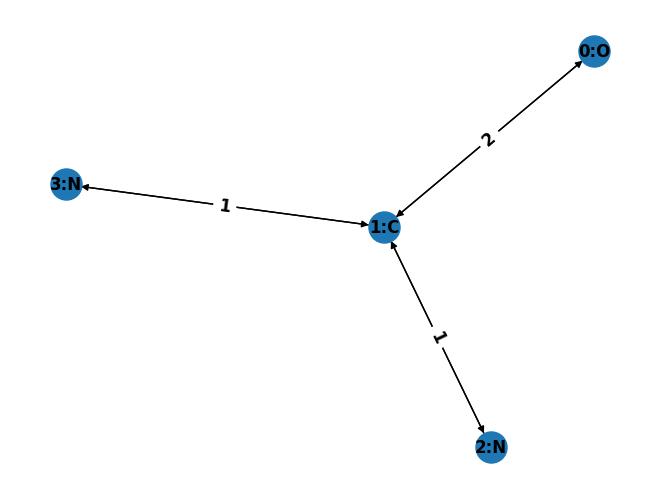

5
current_node 1
softmax_GNN1 tensor([[4.9081e-11, 1.3655e-17, 1.1316e-16, 3.9236e-44, 3.3178e-28, 0.0000e+00,
         1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


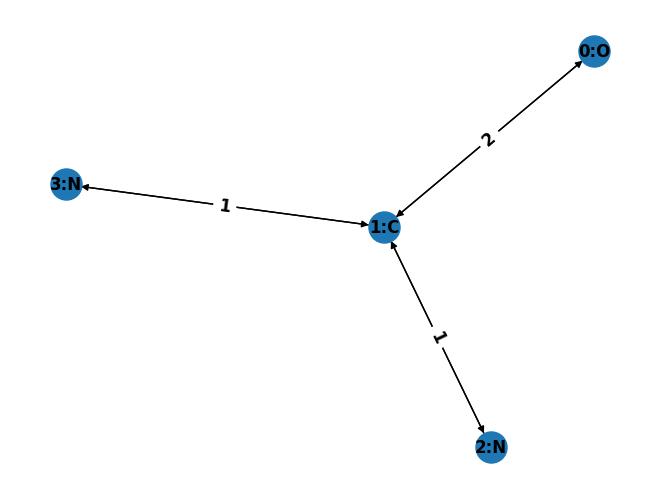

6
current_node 2
softmax_GNN1 tensor([[9.7076e-01, 1.7794e-02, 1.3685e-03, 8.1287e-08, 7.5561e-05, 2.8816e-08,
         9.9986e-03]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[1.4356e-05, 9.9976e-01, 2.2495e-04, 1.9295e-20]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])
softmax_prediction3 tensor([[1.6792e-06, 6.1328e-06, 1.6792e-06, 1.6792e-06, 9.9999e-01]],
       device='cuda:0', grad_fn=<IndexBackward0>)


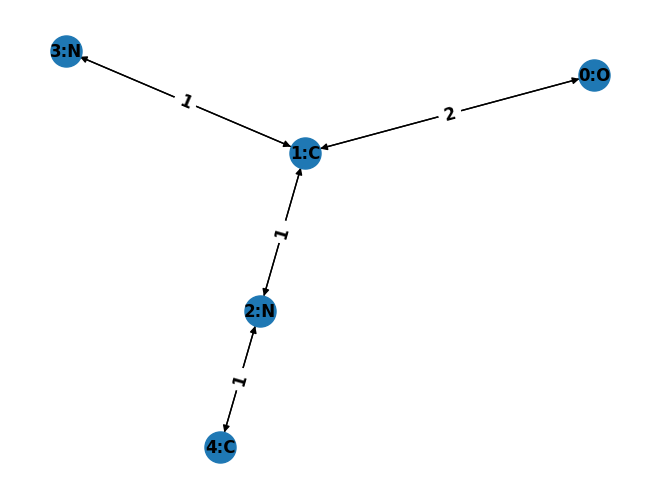

7
current_node 2
softmax_GNN1 tensor([[2.1983e-01, 6.0030e-04, 2.3222e-04, 3.3065e-06, 1.1424e-04, 3.8889e-06,
         7.7921e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


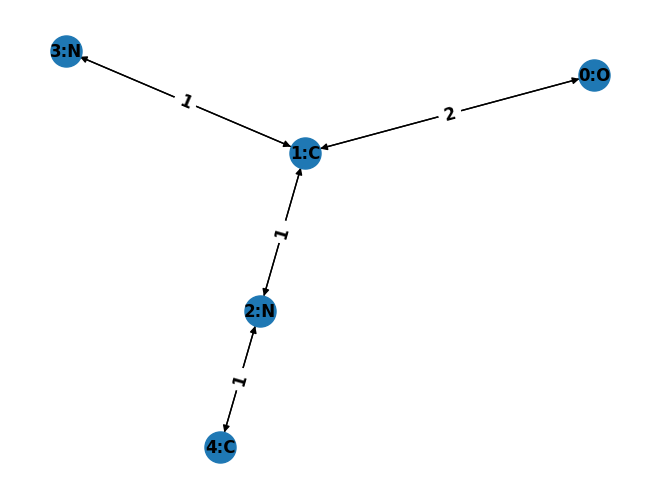

8
current_node 3
softmax_GNN1 tensor([[9.7019e-01, 1.6207e-02, 9.9309e-04, 1.4361e-07, 9.3325e-05, 4.2844e-08,
         1.2512e-02]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[2.8847e-05, 9.9994e-01, 3.3680e-05, 1.9015e-20]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])
softmax_prediction3 tensor([[1.6650e-04, 1.0224e-02, 1.6650e-04, 1.6650e-04, 9.8928e-01]],
       device='cuda:0', grad_fn=<IndexBackward0>)


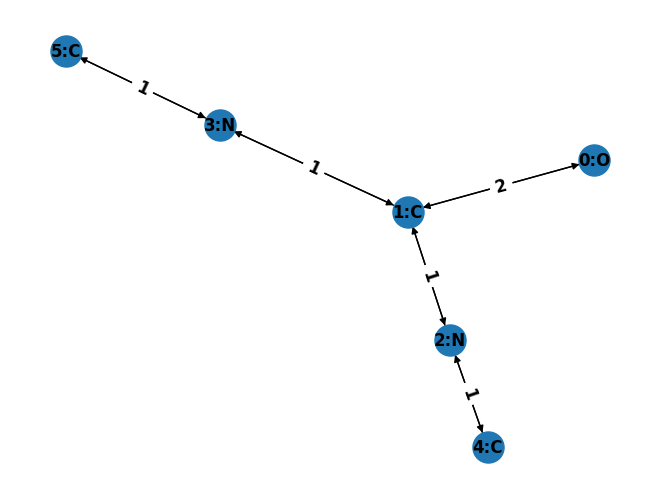

9
current_node 3
softmax_GNN1 tensor([[2.2803e-01, 4.8207e-04, 1.6835e-04, 4.7867e-06, 1.2359e-04, 6.0433e-06,
         7.7119e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


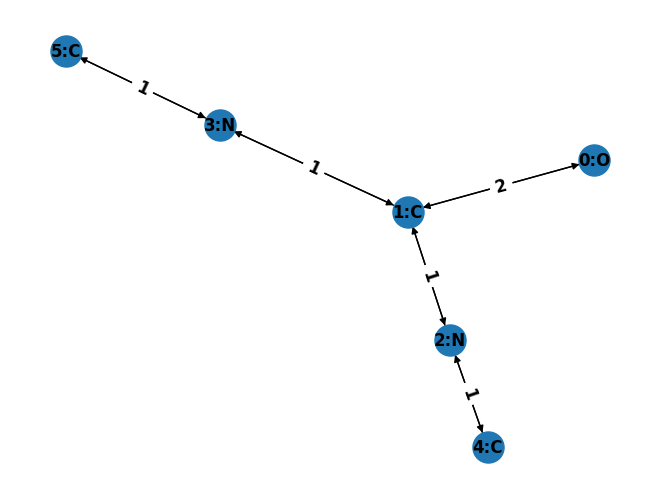

10
current_node 4
softmax_GNN1 tensor([[9.6321e-01, 1.5314e-02, 5.8918e-03, 6.6294e-06, 5.5764e-03, 1.3922e-06,
         9.9972e-03]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[1.9104e-01, 8.0776e-01, 1.1464e-03, 6.2115e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])
softmax_prediction3 tensor([[3.9854e-04, 8.4898e-03, 3.9854e-04, 3.9854e-04, 9.9031e-01]],
       device='cuda:0', grad_fn=<IndexBackward0>)


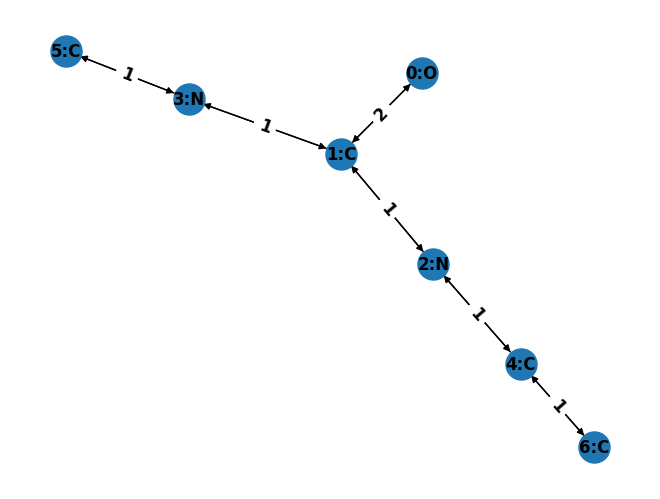

11
current_node 4
softmax_GNN1 tensor([[5.0694e-01, 6.1794e-04, 1.1579e-02, 6.5038e-06, 1.1296e-04, 5.7476e-07,
         4.8075e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[1.1561e-05, 9.9821e-01, 1.7760e-03, 6.2781e-13]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])
softmax_prediction3 tensor([[4.9607e-04, 7.4791e-03, 4.9607e-04, 4.9607e-04, 9.9103e-01],
        [1.0365e-05, 1.1018e-02, 1.0365e-05, 1.0365e-05, 9.8895e-01]],
       device='cuda:0', grad_fn=<IndexBackward0>)


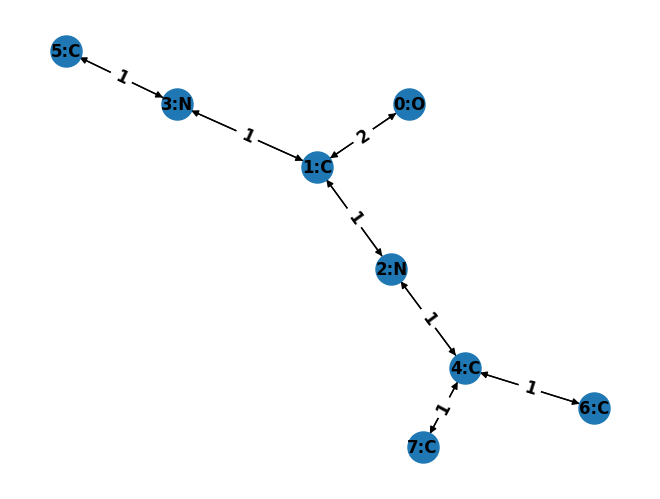

12
current_node 4
softmax_GNN1 tensor([[1.0883e-01, 2.4762e-04, 5.9268e-04, 1.4064e-05, 5.8860e-05, 3.7239e-06,
         8.9025e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


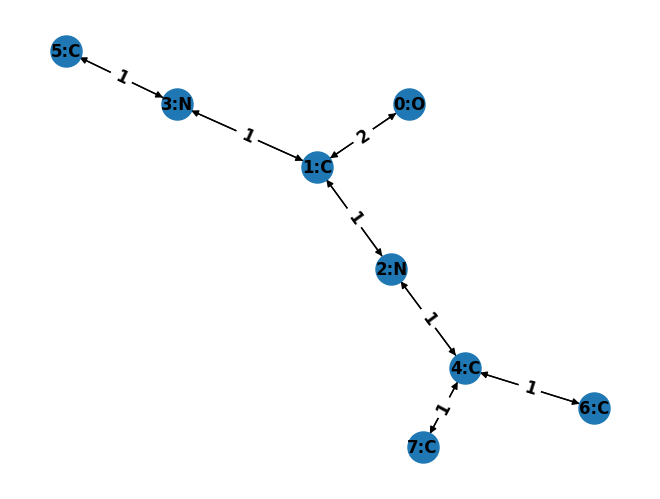

13
current_node 5
softmax_GNN1 tensor([[9.6599e-01, 1.8630e-02, 3.8295e-03, 7.0539e-06, 5.2551e-03, 1.1699e-06,
         6.2911e-03]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[2.5898e-01, 7.4027e-01, 6.9714e-04, 5.3115e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])
softmax_prediction3 tensor([[3.4828e-05, 5.2549e-04, 3.4828e-05, 3.4828e-05, 9.9937e-01],
        [3.4828e-05, 5.2549e-04, 3.4828e-05, 3.4828e-05, 9.9937e-01]],
       device='cuda:0', grad_fn=<IndexBackward0>)


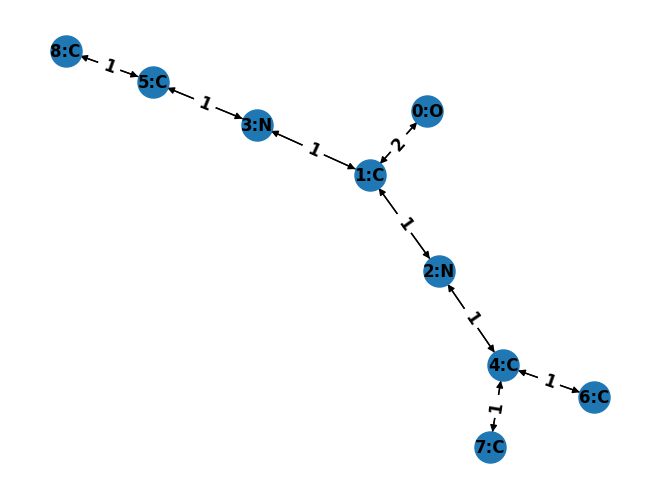

14
current_node 5
softmax_GNN1 tensor([[4.9427e-01, 4.2001e-04, 5.7693e-03, 5.6806e-06, 8.5410e-05, 5.2591e-07,
         4.9945e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


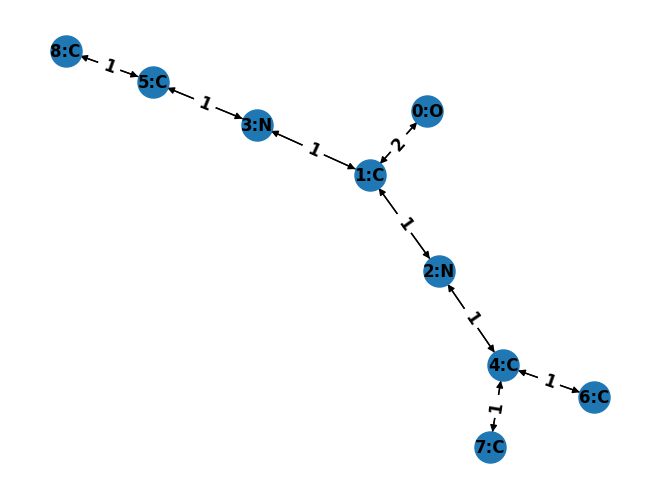

15
current_node 6
softmax_GNN1 tensor([[6.8384e-01, 6.4351e-02, 6.8574e-02, 2.5953e-04, 2.2540e-02, 8.0518e-05,
         1.6035e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


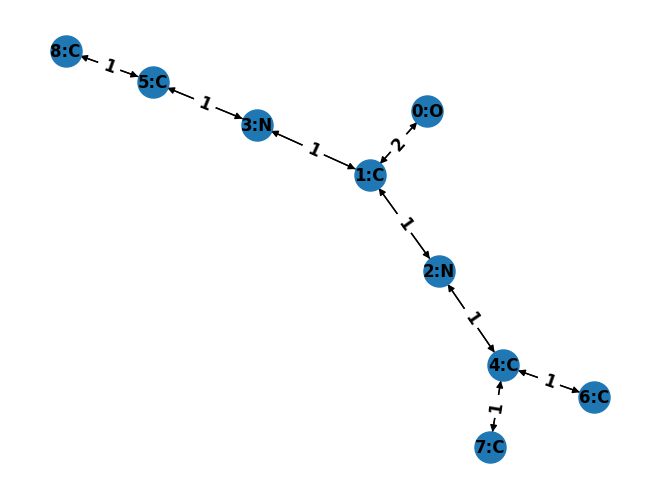

16
current_node 7
softmax_GNN1 tensor([[6.0457e-01, 1.0713e-01, 1.1035e-01, 2.4753e-04, 4.7213e-02, 1.1634e-04,
         1.3037e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[0.3483, 0.6451, 0.0019, 0.0048]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.]])
softmax_prediction3 tensor([[1.3729e-05, 9.1066e-05, 1.3729e-05, 1.3729e-05, 9.9987e-01]],
       device='cuda:0', grad_fn=<IndexBackward0>)


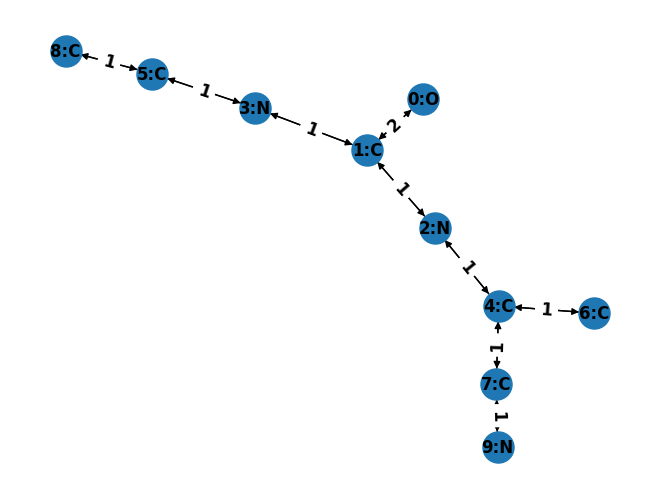

17
current_node 7
softmax_GNN1 tensor([[1.0396e-01, 2.2716e-03, 3.2412e-01, 1.1797e-06, 2.6686e-03, 4.4698e-08,
         5.6698e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[7.6786e-08, 9.3014e-04, 9.9907e-01, 6.8622e-21]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])
softmax_prediction3 tensor([[1.4321e-05, 1.0138e-04, 1.4321e-05, 1.4321e-05, 9.9986e-01],
        [1.0841e-08, 1.0841e-08, 1.0841e-08, 1.0841e-08, 1.0000e+00]],
       device='cuda:0', grad_fn=<IndexBackward0>)


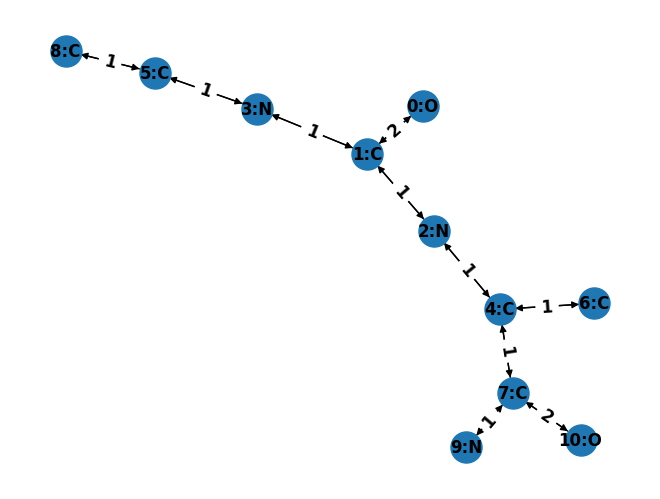

18
current_node 7
softmax_GNN1 tensor([[6.0518e-12, 1.4906e-22, 1.3027e-22, 0.0000e+00, 5.1134e-38, 0.0000e+00,
         1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


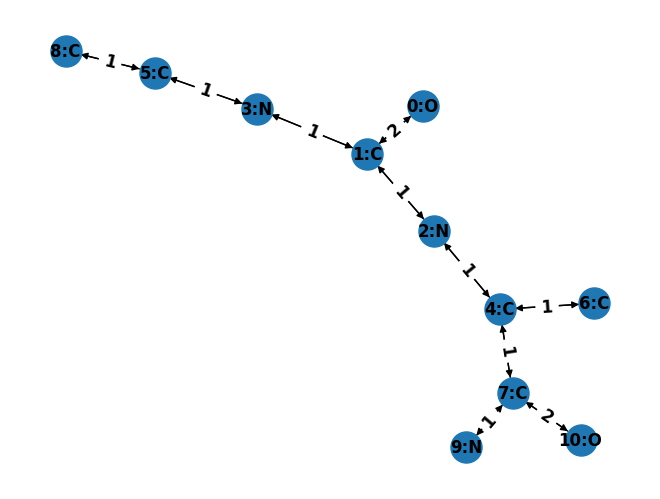

19
current_node 8
softmax_GNN1 tensor([[7.4231e-01, 1.0047e-01, 7.9296e-02, 4.1551e-03, 2.5234e-02, 9.9507e-05,
         4.8438e-02]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[0.4239, 0.5462, 0.0234, 0.0065]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])
softmax_prediction3 tensor([[2.3544e-05, 2.3544e-05, 2.3544e-05, 2.3544e-05, 9.9991e-01],
        [8.8440e-07, 1.2037e-07, 1.2037e-07, 1.2037e-07, 1.0000e+00]],
       device='cuda:0', grad_fn=<IndexBackward0>)


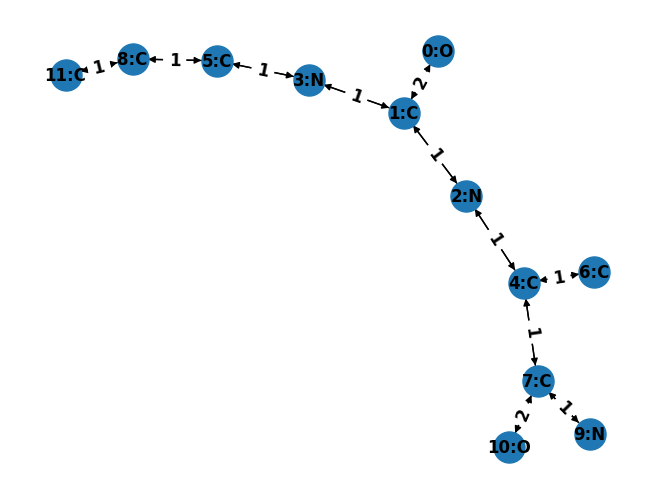

20
current_node 8
softmax_GNN1 tensor([[4.2854e-01, 5.0071e-02, 1.0033e-01, 2.4905e-04, 5.0920e-03, 2.0661e-05,
         4.1570e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


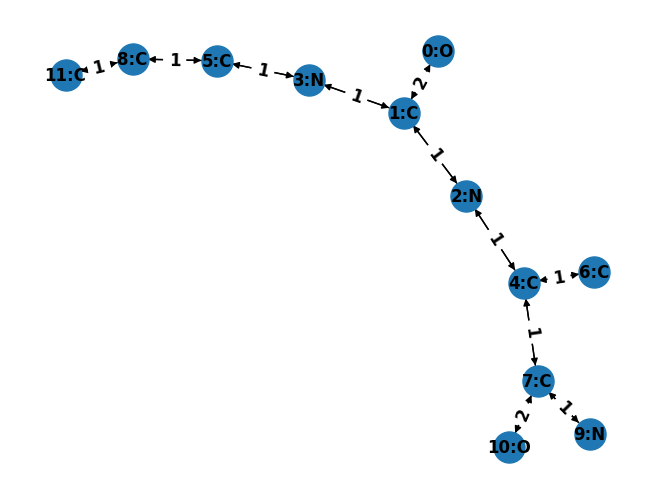

21
current_node 9
softmax_GNN1 tensor([[9.4632e-01, 7.9850e-03, 4.6408e-04, 1.0637e-07, 3.7234e-06, 2.9646e-07,
         4.5229e-02]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[7.1190e-06, 9.9992e-01, 7.2483e-05, 2.4023e-21]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])
softmax_prediction3 tensor([[3.7175e-08, 7.1836e-07, 3.7175e-08, 3.7175e-08, 1.0000e+00],
        [2.9712e-05, 4.7582e-04, 2.9712e-05, 2.9712e-05, 9.9944e-01]],
       device='cuda:0', grad_fn=<IndexBa

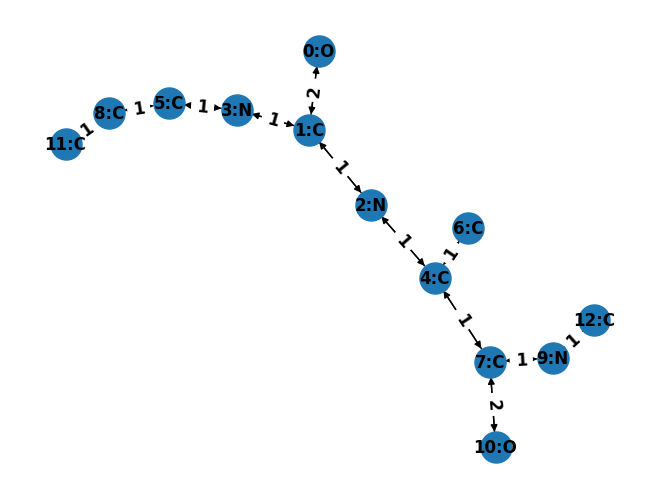

22
current_node 9
softmax_GNN1 tensor([[3.8146e-01, 8.3596e-05, 6.5486e-05, 5.1997e-07, 3.8957e-06, 5.6592e-07,
         6.1839e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


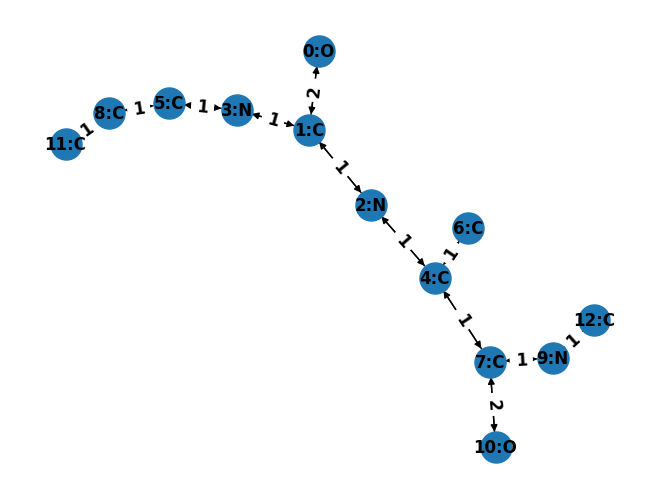

23
current_node 10
softmax_GNN1 tensor([[1.2290e-20, 6.7151e-39, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


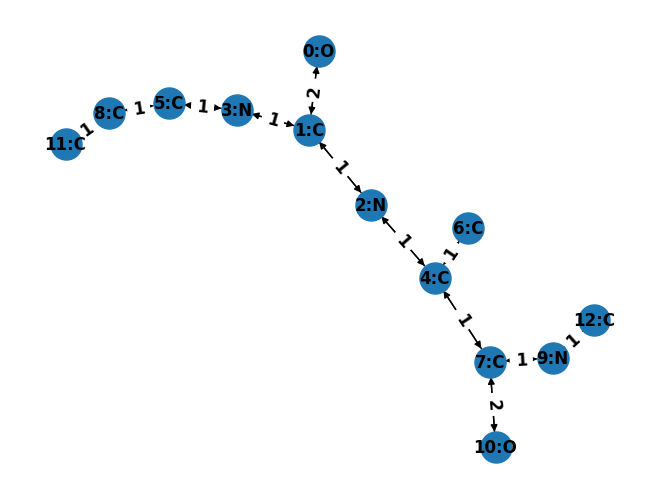

24
current_node 11
softmax_GNN1 tensor([[6.1052e-01, 1.2218e-01, 9.1168e-02, 1.7584e-02, 3.9610e-02, 5.6018e-04,
         1.1838e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[6.7712e-01, 3.1467e-01, 8.1999e-03, 9.7710e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])
softmax_prediction3 tensor([[8.2984e-06, 8.2984e-06, 8.2984e-06, 8.2984e-06, 9.9997e-01]],
       device='cuda:0', grad_fn=<IndexBackward0>)


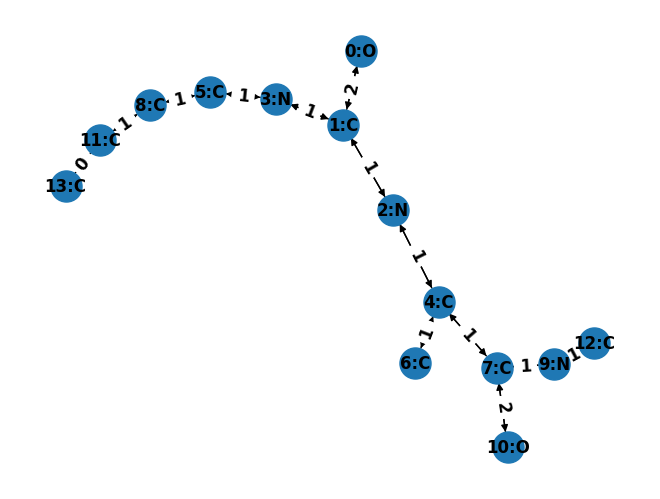

25
current_node 11
softmax_GNN1 tensor([[8.8133e-01, 5.7635e-02, 1.6303e-02, 7.3839e-06, 4.4640e-02, 2.5562e-05,
         5.6098e-05]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[1., 0., 0., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])
softmax_prediction3 tensor([[8.2984e-06, 8.2984e-06, 8.2984e-06, 8.2984e-06, 9.9997e-01],
        [3.1002e-06, 2.0968e-06, 2.0968e-06, 2.0968e-06, 9.9999e-01]],
  

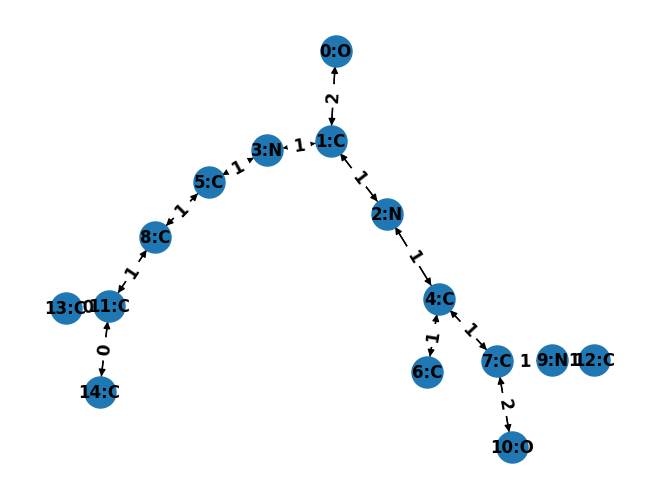

26
current_node 11
softmax_GNN1 tensor([[1.2566e-31, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


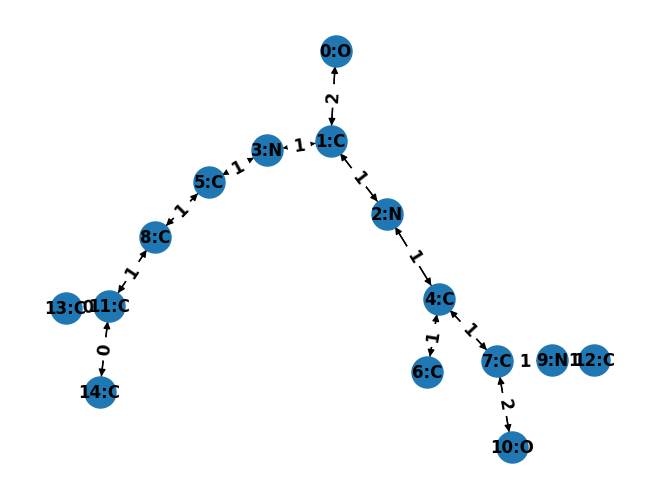

27
current_node 12
softmax_GNN1 tensor([[8.9893e-01, 3.2333e-02, 1.2151e-02, 3.6915e-05, 7.1662e-03, 3.0740e-06,
         4.9379e-02]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[3.3034e-01, 6.6957e-01, 9.1632e-05, 4.0493e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])
softmax_prediction3 tensor([[5.6623e-06, 1.2365e-04, 5.6623e-06, 5.6623e-06, 9.9986e-0

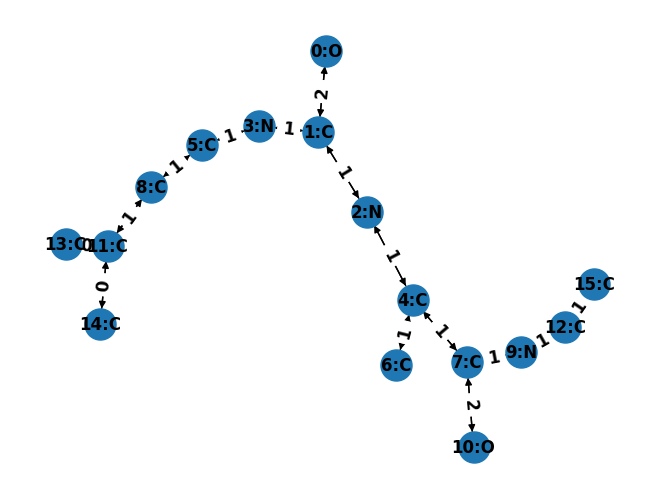

28
current_node 12
softmax_GNN1 tensor([[5.9502e-01, 1.0537e-04, 2.0272e-03, 5.1086e-07, 1.7884e-04, 1.3502e-07,
         4.0266e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[1.3822e-05, 9.9973e-01, 2.5410e-04, 4.8417e-14]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])
softmax_prediction3 tensor([[5.6623e-06, 1.2365e

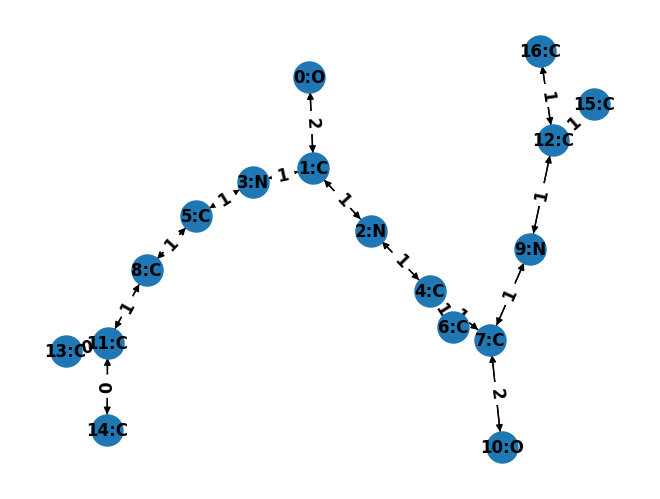

29
current_node 12
softmax_GNN1 tensor([[1.8722e-01, 5.4197e-05, 3.9562e-04, 2.5135e-05, 4.6917e-05, 2.7184e-06,
         8.1226e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[7.2264e-26, 1.0000e+00, 2.5095e-15, 0.0000e+00]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])
softmax_pr

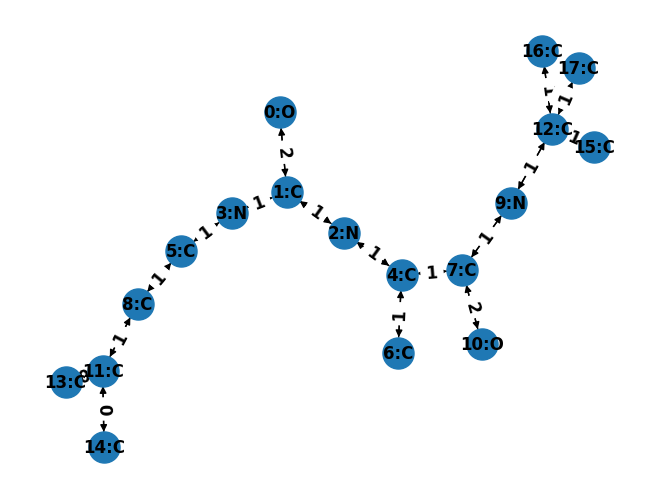

30
current_node 12
softmax_GNN1 tensor([[2.2205e-07, 1.2099e-13, 4.5728e-12, 6.2527e-23, 2.3992e-15, 6.4497e-25,
         1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


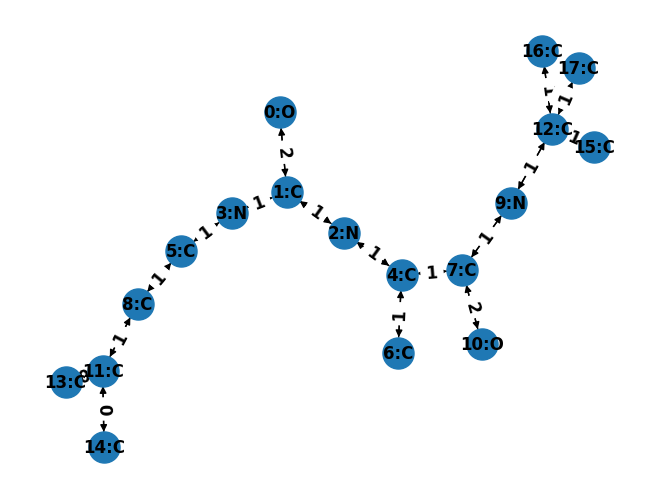

31
current_node 13
softmax_GNN1 tensor([[9.1728e-01, 4.6584e-02, 8.7699e-03, 1.2092e-02, 1.2855e-02, 2.4205e-03,
         6.2456e-07]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[9.7890e-01, 2.1100e-02, 1.2510e-07, 2.2319e-10]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1.

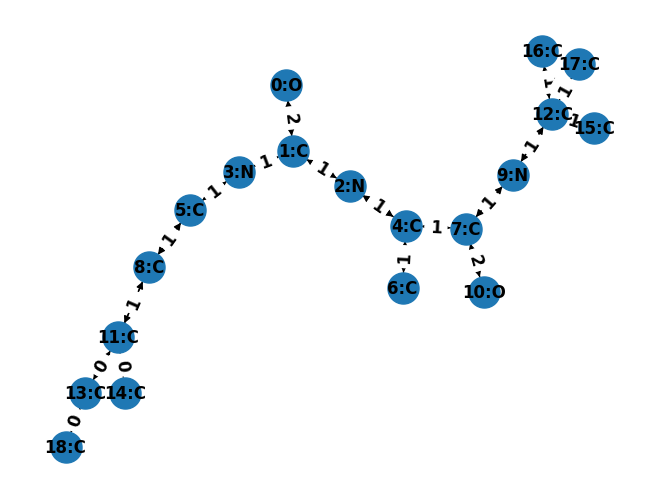

32
current_node 13
softmax_GNN1 tensor([[3.3262e-02, 1.1404e-03, 2.4650e-03, 1.2471e-02, 2.2547e-05, 2.2354e-03,
         9.4840e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


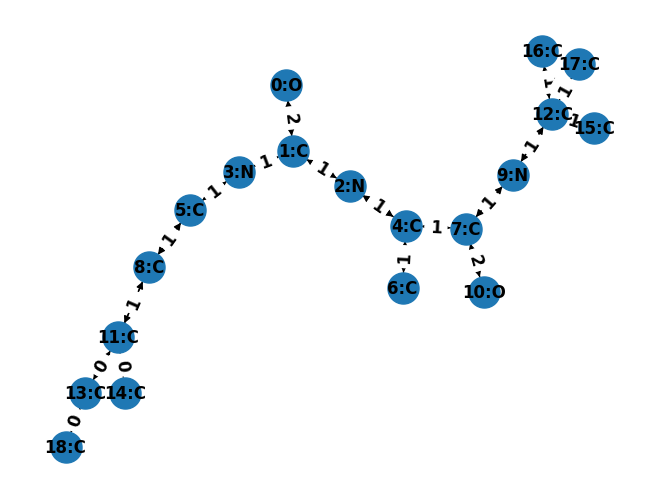

33
current_node 14
softmax_GNN1 tensor([[9.5737e-01, 9.7757e-03, 6.2775e-03, 1.4212e-02, 8.9412e-03, 3.4252e-03,
         2.6969e-07]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[9.9129e-01, 8.7058e-03, 2.7335e-08, 1.6333e-11]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1.

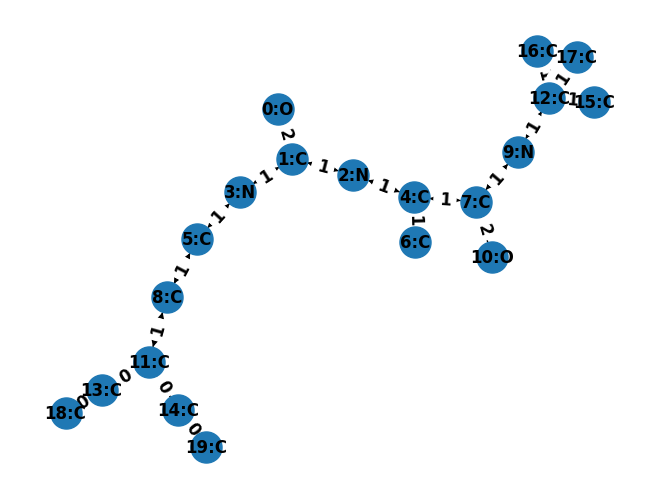

34
current_node 14
softmax_GNN1 tensor([[1.6046e-02, 6.4454e-04, 2.5510e-03, 8.1668e-03, 3.6110e-05, 1.8063e-03,
         9.7075e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


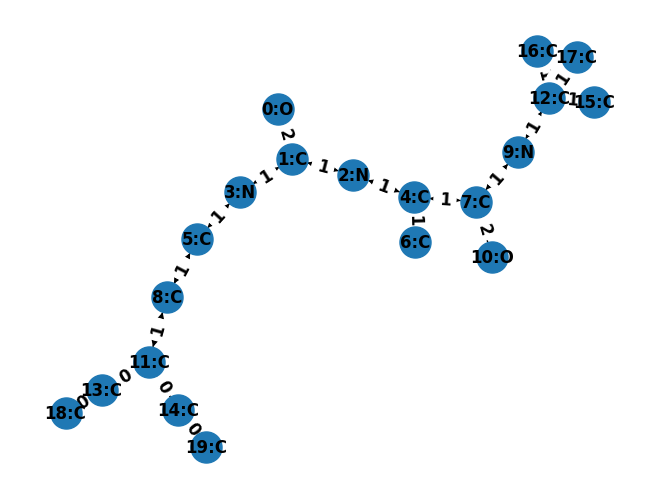

35
current_node 15
softmax_GNN1 tensor([[1.5017e-01, 1.4469e-02, 2.1451e-02, 1.0912e-02, 1.0848e-02, 8.3270e-06,
         7.9214e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


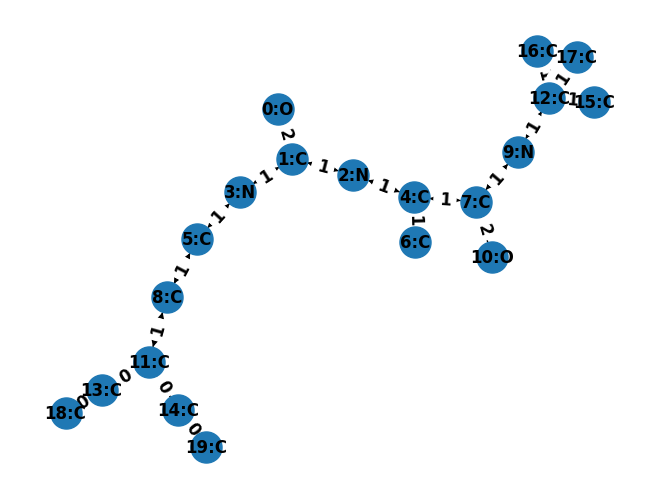

36
current_node 16
softmax_GNN1 tensor([[3.9369e-02, 7.3427e-03, 1.1302e-02, 2.9070e-03, 5.2109e-03, 5.3673e-06,
         9.3386e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


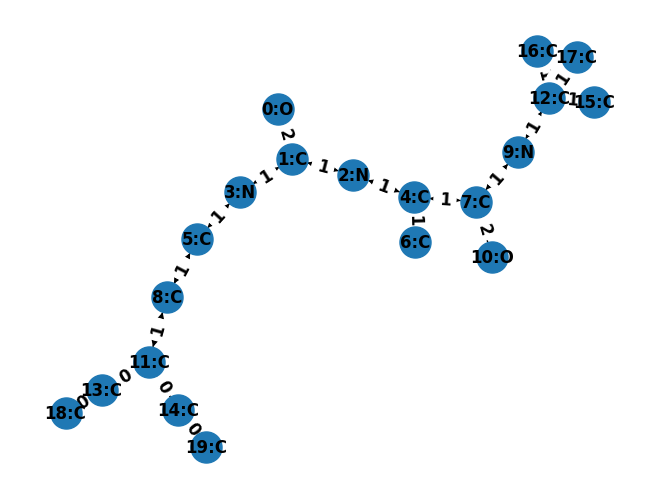

37
current_node 17
softmax_GNN1 tensor([[7.4828e-03, 2.1351e-03, 2.9134e-03, 2.4474e-04, 9.0050e-04, 1.4464e-06,
         9.8632e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


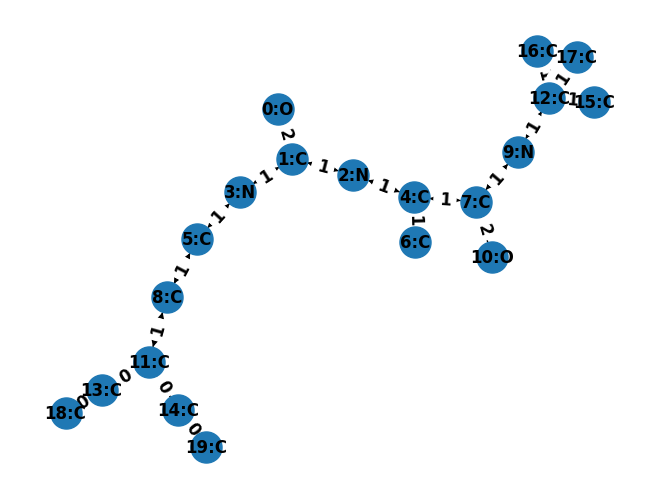

38
current_node 18
softmax_GNN1 tensor([[9.2369e-01, 3.2714e-02, 1.6159e-02, 2.3192e-02, 4.9888e-04, 3.6908e-03,
         5.1139e-05]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[9.6658e-01, 3.3415e-02, 2.4844e-08, 3.0126e-12]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1.

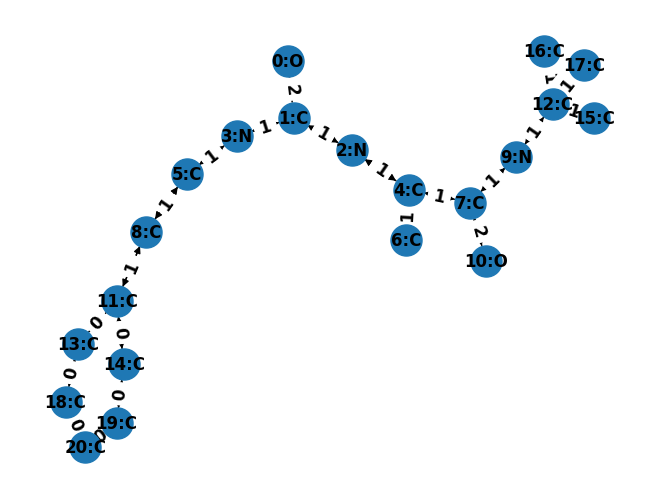

39
current_node 18
softmax_GNN1 tensor([[3.8219e-02, 4.5124e-03, 3.0474e-02, 2.8254e-02, 5.6993e-04, 9.7944e-03,
         8.8818e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


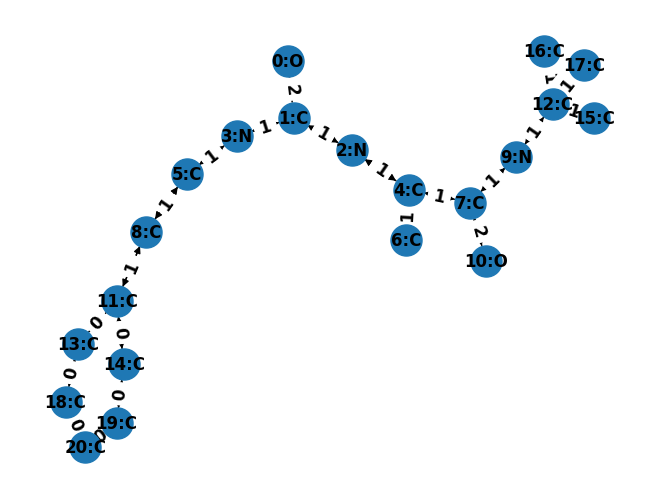

40
current_node 19
softmax_GNN1 tensor([[0.0710, 0.0094, 0.0602, 0.0536, 0.0012, 0.0193, 0.7852]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


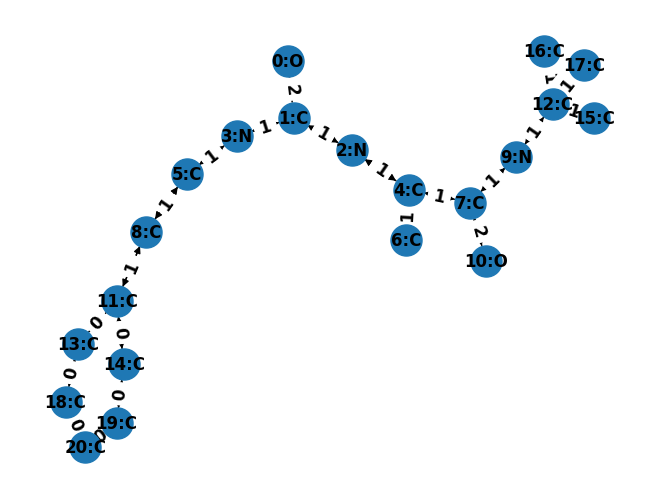

41
current_node 20
softmax_GNN1 tensor([[0.2304, 0.1104, 0.1049, 0.1084, 0.0335, 0.0742, 0.3383]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
softmax_GNN2 tensor([[2.0586e-05, 9.9998e-01, 1.5244e-06, 1.3492e-15]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
   

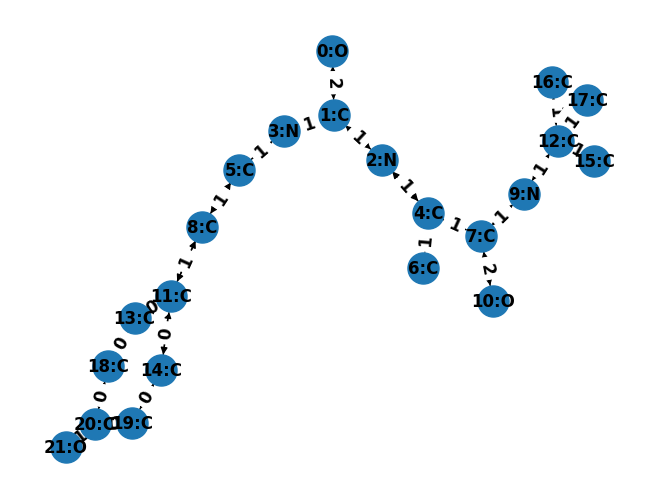

42
current_node 20
softmax_GNN1 tensor([[9.2793e-32, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


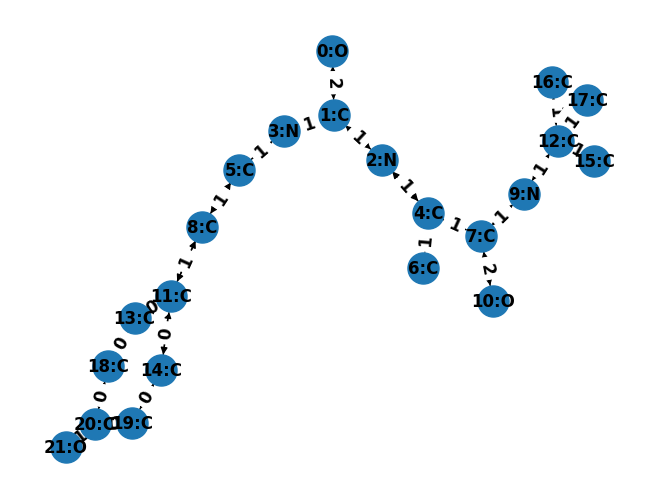

43
current_node 21
softmax_GNN1 tensor([[6.0746e-01, 1.4893e-05, 2.2884e-06, 3.1977e-06, 1.6427e-04, 8.6132e-09,
         3.9235e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


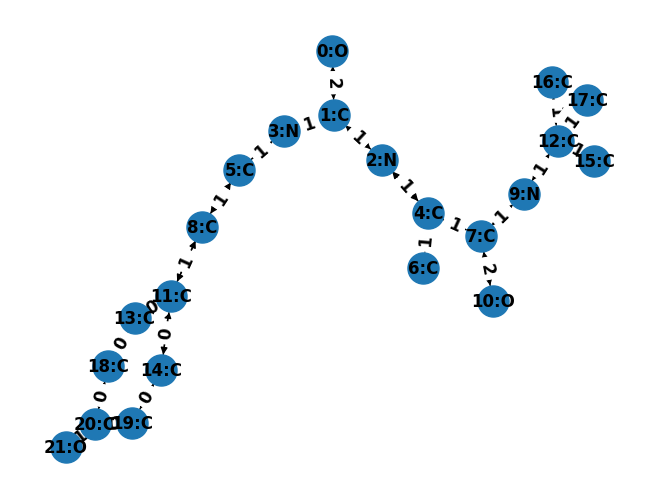

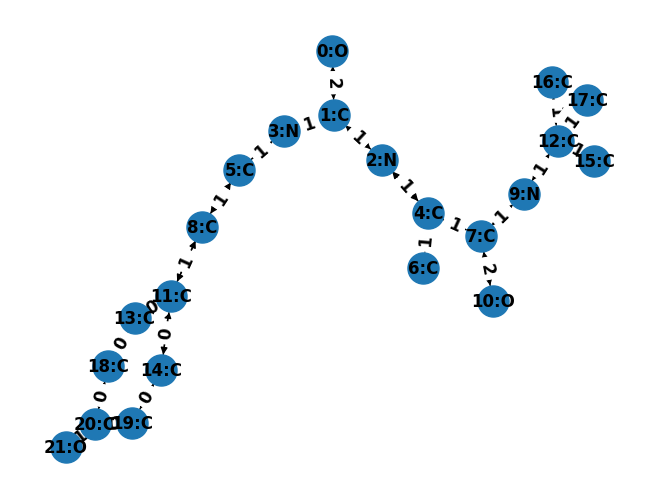

In [18]:
output, queue = full_generation()
graphX = torch_geometric_to_networkx(output)
plot_graph(graphX,  atom_conversion_type='onehot', encoding_type = 'reduced')

In [19]:
output

DataBatch(x=[22, 7], edge_index=[2, 44], edge_attr=[44, 4], batch=[1])

In [20]:
from rdkit import Chem
import torch
import torch_geometric as tg

def tensor_to_smiles(node_features, edge_index, edge_attr):
    # Create an empty editable molecule
    mol = Chem.RWMol()

    # Define atom mapping
    atom_mapping = {
        0: 'C',
        1: 'N',
        2: 'O',
        3: 'F',
        4: 'S',
        5: 'Cl',
    }

    # Add atoms
    for atom_feature in node_features:
        atom_idx = atom_feature[:6].argmax().item()
        atom_symbol = atom_mapping.get(atom_idx)
        atom = Chem.Atom(atom_symbol)
        mol.AddAtom(atom)

    # Define bond type mapping
    bond_mapping = {
        0: Chem.rdchem.BondType.AROMATIC,
        1: Chem.rdchem.BondType.SINGLE,
        2: Chem.rdchem.BondType.DOUBLE,
        3: Chem.rdchem.BondType.TRIPLE,
    }

    # Add bonds
    for start, end, bond_attr in zip(edge_index[0], edge_index[1], edge_attr):
        bond_type_idx = bond_attr[:4].argmax().item()
        bond_type = bond_mapping.get(bond_type_idx)

        # RDKit ignores attempts to add a bond that already exists,
        # so we need to check if the bond exists before we add it
        if mol.GetBondBetweenAtoms(start.item(), end.item()) is None:
            mol.AddBond(start.item(), end.item(), bond_type)

    # Convert the molecule to SMILES
    smiles = Chem.MolToSmiles(mol)

    return smiles

In [21]:
tensor_to_smiles(output.x, output.edge_index, output.edge_attr)

'CC(NC(=O)NCCc1ccc(O)cc1)C(=O)NC(C)(C)C'

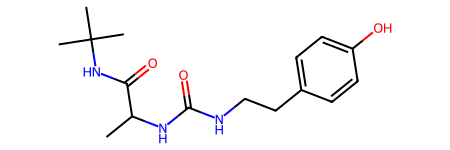

In [22]:
#plot the SMILES 
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

mol = Chem.MolFromSmiles(tensor_to_smiles(output.x, output.edge_index, output.edge_attr))
mol